In [1]:
import numpy as np
from imp import load_source

import torch
from torch import load, quantization, backends

from eprt import KitModel
from helper import *

from scipy.ndimage.filters import gaussian_filter
import math

In [2]:
RES_PACK = {'rt': 224, 'i': 256, 'ii': 368, 'iii': 480, 'iv': 600, 'rt_lite': 224, 'i_lite': 256, 'ii_lite': 368}
MEANS = [0.406, 0.456, 0.485]
STDS = [0.225, 0.224, 0.229]

In [3]:
MainModel = load_source('MainModel', "eprt.py")
model = torch.load("weights/EfficientPoseRT")
model.eval()
qconfig = quantization.get_default_qconfig('qnnpack')
res = RES_PACK["rt"]

/usr/local/lib/python3.9/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'MainModel.KitModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.9/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.9/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Mod

In [4]:
image_transformations = get_transforms((res, res), MEANS, STDS)

In [5]:
model, res

(KitModel(
   (stem_conv_res1_convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
   (stem_bn_res1_FusedBatchNorm_1): BatchNorm2d(32, eps=0.0010000000474974513, momentum=0.0, affine=True, track_running_stats=True)
   (block1a_dwconv_res1_depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
   (block1a_bn_res1_FusedBatchNorm_1): BatchNorm2d(32, eps=0.0010000000474974513, momentum=0.0, affine=True, track_running_stats=True)
   (block1a_se_reduce_res1_convolution): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
   (block1a_se_expand_res1_convolution): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
   (block1a_project_conv_res1_convolution): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (block1a_project_bn_res1_FusedBatchNorm_1): BatchNorm2d(16, eps=0.0010000000474974513, momentum=0.0, affine=True, track_running_stats=True)
   (block2a_expand_conv_res1_convolution): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1

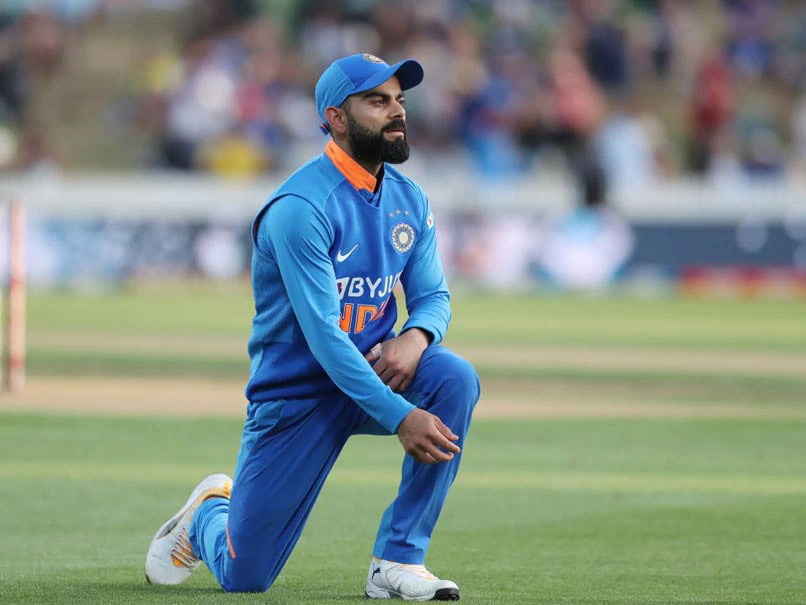

In [6]:
img = get_image_from_url("https://c.ndtvimg.com/2020-05/d35d9bog_virat-kohli-afp_625x300_18_May_20.jpg")
img

In [13]:
out = image_transformations(img)
_, image_height, image_width = out.size()
out = model(out.view(1, *out.size())).detach().numpy()
out = np.rollaxis(out, 1, 4)
out.shape

In [8]:
frame_coords = extract_coordinates(out[0], image_height, image_width, real_time=False)

In [9]:
frame_coords

[('head_top', 0.4575892857142857, 0.09151785714285714),
 ('upper_neck', 0.44419642857142855, 0.24776785714285715),
 ('right_shoulder', 0.36830357142857145, 0.328125),
 ('right_elbow', 0.41294642857142855, 0.5602678571428571),
 ('right_wrist', 0.49776785714285715, 0.6808035714285714),
 ('thorax', 0.43526785714285715, 0.30580357142857145),
 ('left_shoulder', 0.49330357142857145, 0.3013392857142857),
 ('left_elbow', 0.5200892857142857, 0.44419642857142855),
 ('left_wrist', 0.5111607142857143, 0.5513392857142857),
 ('pelvis', 0.44419642857142855, 0.546875),
 ('right_hip', 0.3950892857142857, 0.5647321428571429),
 ('right_knee', 0.3325892857142857, 0.8147321428571429),
 ('right_ankle', 0.3013392857142857, 0.9174107142857143),
 ('left_hip', 0.484375, 0.5424107142857143),
 ('left_knee', 0.5602678571428571, 0.6227678571428571),
 ('left_ankle', 0.4888392857142857, 0.9040178571428571)]

In [10]:
image = annotate_image(img, frame_coords)

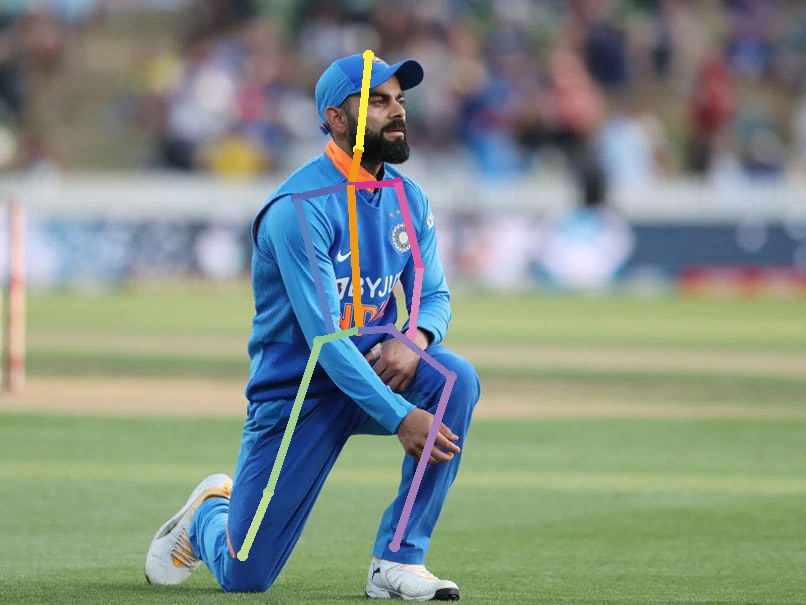

In [11]:
image

In [14]:
torch.onnx.export(model, out.view(1, *out.size()), "sample.onnx")

eprt.py:147: TracerWarning: torch.Tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  self.pass1_block1_mbconv1_skeleton_conv1_eswish_mul_x = torch.autograd.Variable(torch.Tensor([1.25]), requires_grad=False)
eprt.py:148: TracerWarning: torch.Tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  self.pass1_block1_mbconv1_skeleton_dconv1_eswish_mul_x = torch.autograd.Variable(torch.Tensor([1.25]), requires_grad=False)
eprt.py:149: TracerWarning: torch.Tensor results are registered as constants in the trace. You can safely ignore this

/Users/yashbonde/Desktop/wrk/box_of_ai_tools/Human_Pose_Estimation/EfficientPose/helper.py:75: TracerWarning: torch.Tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  return Tensor(bilinear_kernel)
